<a href="https://colab.research.google.com/github/ConstDahoud/simple_dnn/blob/main/01_sine_regression_with_simple_dnn_using_gradient_tape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sine regression with simple dnn using gradient tape

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 6)

import tensorflow as tf
assert tf.__version__ >= "2.0"

import numpy as np
import matplotlib.pyplot as plt

## Generate the data

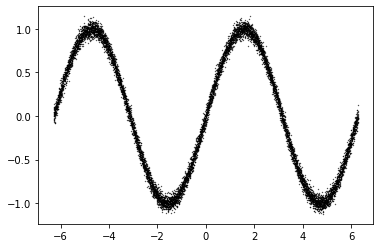

In [2]:
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, np.newaxis]    # inputs shape: (10000, 1)
noise = 0.05 * np.random.normal(size=[len(inputs), 1])
outputs = np.sin(inputs) + noise    # outputs shape: (10000, 1)

plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')

## Define the simple dnn model

In [3]:
class Simple_dnn(tf.Module):
    def __init__(self):
        # create weight and bias matrixes
        initializer = tf.initializers.GlorotUniform()
        W0 = tf.Variable(initializer(shape=[1, 20]), dtype=tf.float32, name='W0')
        W1 = tf.Variable(initializer(shape=[20, 20]), dtype=tf.float32, name='W1')
        W2 = tf.Variable(initializer(shape=[20, 1]), dtype=tf.float32, name='W2')

        b0 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b0')
        b1 = tf.Variable(tf.zeros(shape=[20]),dtype=tf.float32, name='b1')
        b2 = tf.Variable(tf.zeros(shape=[1]), dtype=tf.float32, name='b2')

        self.weights = [W0, W1, W2]
        self.biases = [b0, b1, b2]
        self.activations = [tf.nn.relu, tf.nn.relu, None]
    
    def __call__(self, x):
        layer = x
        for W, b, activation in zip(self.weights, self.biases, self.activations):
            layer = tf.matmul(layer, W) + b
            if activation is not None:
                layer = activation(layer)
        output_pred = layer
    
        return output_pred

## Define random batch function to get a random subset of the training data

In [4]:
def random_batch(inputs, outputs, batch_size=32):
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = tf.Variable(inputs[indices], dtype=tf.float32, name='input')
    output_batch = tf.Variable(outputs[indices], dtype=tf.float32, name='output')
    return input_batch, output_batch

## Train the model

In [5]:
simple_dnn = Simple_dnn()
optimizer = tf.optimizers.Adam()    # create optimizer

# run training
batch_size = 32
for training_step in range(10001):
    input_batch, output_batch = random_batch(inputs, outputs, batch_size=batch_size)
    
    with tf.GradientTape() as tape:
        # forward pass
        output_pred = simple_dnn(input_batch)
        # compute the loss
        mse = tf.reduce_mean(tf.square(output_pred - output_batch))
        # compute gradients(Back propagation)
        grads  = tape.gradient(mse, simple_dnn.trainable_variables)
        # perform a gradient descent step
        optimizer.apply_gradients(zip(grads, simple_dnn.trainable_variables))
        
    if training_step % 1000 == 0:
        print(f'{training_step:04d} mse: {mse:.3f}')

0000 mse: 0.965
1000 mse: 0.086
2000 mse: 0.068
3000 mse: 0.088
4000 mse: 0.045
5000 mse: 0.023
6000 mse: 0.007
7000 mse: 0.005
8000 mse: 0.004
9000 mse: 0.004
10000 mse: 0.003


## Test the model

In [6]:
test_input = tf.Variable(inputs, dtype=tf.float32, name='input')
test_output = tf.Variable(outputs, dtype=tf.float32, name='output')
test_output_pred = simple_dnn(test_input)

## Plot the result

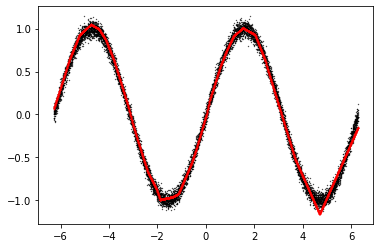

In [7]:
plt.scatter(inputs[:, 0], test_output[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], test_output_pred[:, 0], c='r', marker='o', s=0.1)